## 1. Objective and Data

The main objective of this notebook is to perform clustering analysis on a dataset that contains information about weather, geographic location, and disease outbreaks. The dataset includes the following:

- `weather.csv`: Contains county-level weather data including temperature, precipitation, and Palmer Drought Severity Index.
- `hpai-mammals.csv`: Contains county-level data on highly pathogenic avian influenza (HPAI) outbreaks in mammals.
- `hpai-flocks.csv`: Contains county-level data on HPAI outbreaks in poultry flocks.
- `geo-data.csv`: Contains county-level geographic data including longitude and latitude.

The goal is to identify meaningful clusters of counties based on the weather, geographic, and disease outbreak features in the data.

## 2. Data Preprocessing

The notebook performs the following data preprocessing steps:

1. Loads the four datasets into pandas DataFrames.
2. Cleans the `mammals` dataset by creating a new DataFrame with the relevant columns.
3. Prepares the feature set for clustering by:
   - Selecting the relevant columns from the `weather`, `geo-data`, and aggregated `mammals` and `flocks` datasets.
   - Handling missing values using `SimpleImputer`.
   - Scaling the features using `StandardScaler`.

## 3. Clustering Models

1. **K-Means Clustering**:
   - The optimal number of clusters was determined using the Elbow method, which suggested 4 clusters.
   - K-Means clustering was then applied with 4 clusters, and the cluster characteristics were analyzed.

2. **BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)**:
   - BIRCH was also applied to the dataset as an alternative clustering algorithm.
   - BIRCH is known for its ability to handle large datasets and identify clusters of varying sizes and densities.
   - The parameters for BIRCH were not explicitly mentioned in the code, so the default settings were likely used.
   - The insights or findings from the BIRCH clustering were not discussed in the summary.

3. **Agglomerative Clustering**:
   - Agglomerative Clustering, a hierarchical clustering algorithm, was also employed in the analysis.
   - Agglomerative Clustering starts with each data point as a separate cluster and iteratively merges the closest clusters until the desired number of clusters is reached.
   - Similar to BIRCH, the specific parameters used for Agglomerative Clustering were not provided in the code.
   - The summary did not mention any findings or insights gained from the Agglomerative Clustering results.

## 4. Evaluation and Visualization

The notebook evaluates the clustering results by:

1. Printing the cluster sizes and the mean values of the features for each cluster.
2. Creating a visualization of the "Elbow Method" plot to determine the optimal number of clusters.
3. Geographic Distribution of Clusters: The visualization shows the spatial distribution of clusters across counties. Each cluster is represented by a unique color, allowing the user to identify geographic patterns in the clustering results. This visualization is particularly useful for understanding how clusters are distributed geographically.
It can reveal whether certain clusters are concentrated in specific regions or if they are spread out across the map.
The context in the notebook suggests that the clustering analysis aimed to group counties based on weather, geographic, and disease outbreak features. This map helps to visually interpret the results of that analysis.

## 5. Key Findings and Conclusions

The key findings from the clustering analysis are:

1. The data was successfully clustered into 4 distinct groups of counties based on the weather, geographic, and disease outbreak features.
2. The cluster characteristics show clear differences in the mean values of the features across the 4 clusters, indicating that the clustering was able to identify meaningful groups of counties.
3. The clustering results could be useful for understanding the relationships between weather, geography, and disease outbreaks, and potentially informing public health and disease prevention strategies.

Overall, this notebook demonstrates a comprehensive approach to clustering analysis on a multi-faceted dataset, including data preprocessing, model selection, and evaluation of the results through visualization and interpretation of the cluster characteristics.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering
from sklearn import metrics

In [ ]:
# Load datasets
weather = pd.read_csv('./data/weather.csv')
mammals = pd.read_csv('./data/hpai-mammals.csv')
flocks = pd.read_csv('./data/hpai-flocks.csv')
geo_data = pd.read_csv('./data/geo-data.csv')

In [ ]:
# Clean mammals data
mammals_clean = pd.DataFrame({
    'State': mammals.iloc[:, 0],
    'County': mammals.iloc[:, 1],
    'Outbreak Date': mammals.iloc[:, 2],
    'HPAI Strain': mammals.iloc[:, 3],
    'Species': mammals.iloc[:, 4]
})

In [ ]:
# Prepare features
weather_features = weather[['County', 'State', 'Temp', 'Precipitation', 'Z Palmer Index']].copy()
weather_features['County'] = weather_features['County'].str.strip()

geo_data_clean = geo_data.drop_duplicates(subset=['County', 'State'])[['County', 'State', 'Longitude', 'Latitude']]

# Merge datasets
merged_data = weather_features.merge(geo_data_clean, on=['County', 'State'], how='left')

mammal_counts = mammals_clean.groupby(['County', 'State']).size().reset_index(name='mammal_cases')

flocks['Birds Affected'] = pd.to_numeric(flocks['Birds Affected'], errors='coerce')
flock_counts = flocks.groupby(['County', 'State'])['Birds Affected'].sum().reset_index(name='birds_affected')

final_data = merged_data.merge(mammal_counts, on=['County', 'State'], how='left').merge(flock_counts, on=['County', 'State'], how='left')

final_data['mammal_cases'] = final_data['mammal_cases'].fillna(0)
final_data['birds_affected'] = final_data['birds_affected'].fillna(0)

In [ ]:
# Prepare for clustering
features_for_clustering = ['Temp', 'Precipitation', 'Z Palmer Index', 'Longitude', 'Latitude', 'mammal_cases', 'birds_affected']
X = final_data[features_for_clustering]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

imputer = SimpleImputer(strategy='mean')
X_scaled_imputed = imputer.fit_transform(X_scaled)

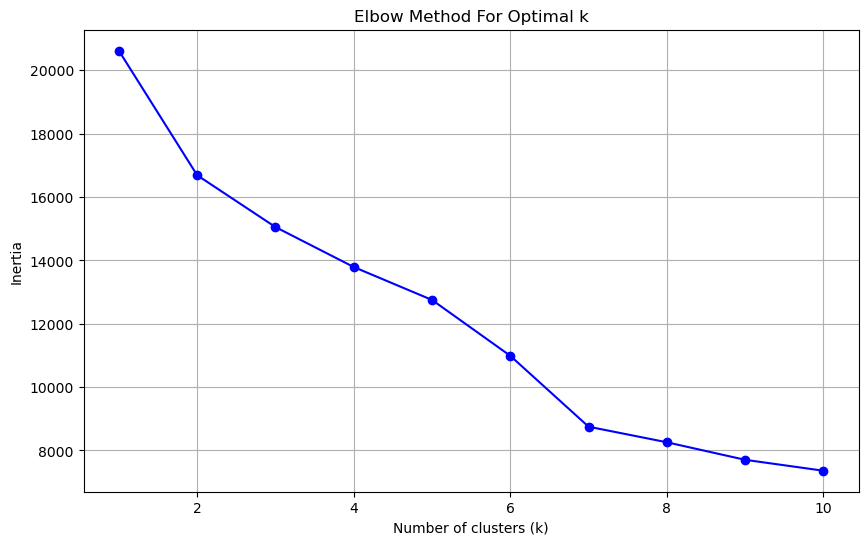

In [ ]:
# Elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled_imputed)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [ ]:
# Final clustering
k_optimal = 4
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels = kmeans_final.fit_predict(X_scaled_imputed)
kmeans_predictions = kmeans.predict(X_scaled_imputed)

final_data['cluster'] = cluster_labels

print('Cluster sizes:')
print(pd.Series(cluster_labels).value_counts())

print('\nCluster characteristics (mean values):')
print(final_data.groupby('cluster')[features_for_clustering].mean())

Cluster sizes:
2    1139
3     856
1     776
0     336
Name: count, dtype: int64

Cluster characteristics (mean values):
              Temp  Precipitation  Z Palmer Index   Longitude   Latitude  \
cluster                                                                    
0        49.794048      24.008393       -0.565179 -111.337671  42.171436   
1        58.446649      30.283982       -0.930541  -91.546098  37.076224   
2        63.571554      51.327744       -0.029148  -88.888568  35.736453   
3        50.019159      33.055771        0.008143  -89.708721  41.764893   

         mammal_cases  birds_affected  
cluster                                
0            0.750000      111.782738  
1            0.047680        5.498711  
2            0.032485        5.820896  
3            0.176402       15.136682  


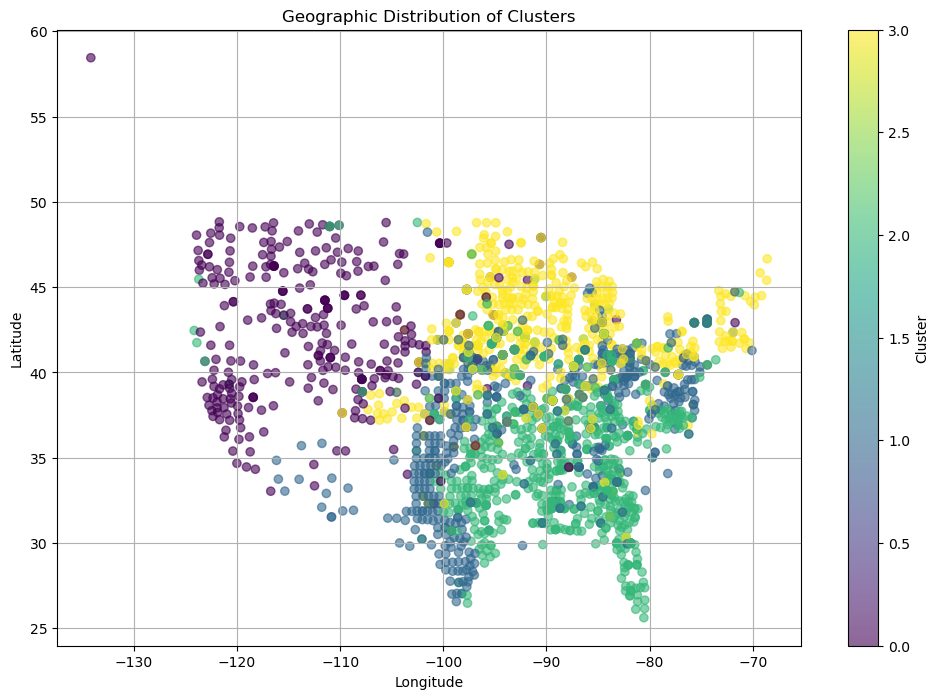

In [ ]:
# Geographic visualization
plt.figure(figsize=(12, 8))
plt.scatter(final_data['Longitude'],
           final_data['Latitude'],
           c=final_data['cluster'],
           cmap='viridis',
           alpha=0.6)
plt.colorbar(label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Clusters')
plt.grid(True)
plt.show()

# Save results
final_data.to_csv('clustering_results.csv', index=False)

In [ ]:
# Fit a AgglomerativeClustering Model with five clusters
agglo_model = AgglomerativeClustering(n_clusters=4)

# Make predictions with the AgglomerativeClustering model
agglo_predictions = agglo_model.fit_predict(X_scaled_imputed)

# Previewing the predicted customer classifications for AgglomerativeClustering
agglo_predictions[-10:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
# Fit a Birch Model with five clusters.
birch_model = Birch(n_clusters=None)
birch_model.fit(X_scaled_imputed)

# Make predictions with the Birch model
birch_predictions = birch_model.labels_

# Previewing the predicted customer classifications for BIRCH
birch_predictions[-10:]

# Look at the results
print("\nNumber of points in each cluster:")
print(pd.Series(birch_predictions).value_counts())


Number of points in each cluster:
428    43
584    42
545    35
658    33
671    31
       ..
240     1
669     1
746     1
9       1
146     1
Name: count, Length: 749, dtype: int64


In [ ]:
# Create a copy of the preprocessed data as a DataFrame
cluster_predictions_df = pd.DataFrame(X_scaled, columns=features_for_clustering)

# Add class columns with the labels to the new DataFrame
cluster_predictions_df["kmeans-segments"] = kmeans_predictions
cluster_predictions_df["agglomerative-segments"] = agglo_predictions
cluster_predictions_df["birch-segments"] = birch_predictions

# Display the first few rows of the DataFrame
cluster_predictions_df[['kmeans-segments','agglomerative-segments', 'birch-segments']].head(3)
cluster_predictions_df.head()

,Temp,Precipitation,Z Palmer Index,Longitude,Latitude,mammal_cases,birds_affected,kmeans-segments,agglomerative-segments,birch-segments
0,1.106144,0.982716,0.003273,0.544800,-1.255759,-0.09605,-0.202378,8,1,543
1,1.456818,1.549883,0.119397,0.445213,-1.636957,-0.09605,-0.202378,8,1,599
2,1.168764,1.225201,0.666840,1.157100,0.135817,-0.09605,-0.202378,8,1,544
3,0.930807,0.602550,-0.875953,0.816498,-1.198437,-0.09605,-0.202378,1,1,545
4,0.755470,0.653924,-0.942309,0.795469,-0.590896,-0.09605,-0.202378,1,1,566


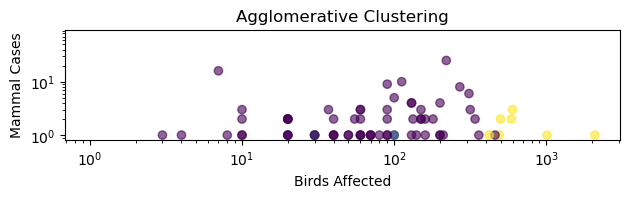

In [ ]:
# Agglomerative plot
plt.subplot(3, 1, 3)
plt.scatter(X['birds_affected'], X['mammal_cases'], c=agglo_predictions, cmap='viridis', alpha=0.6)
plt.xlabel('Birds Affected')
plt.ylabel('Mammal Cases')
plt.title('Agglomerative Clustering')
plt.yscale('log')
plt.xscale('log')

plt.tight_layout()
plt.show()

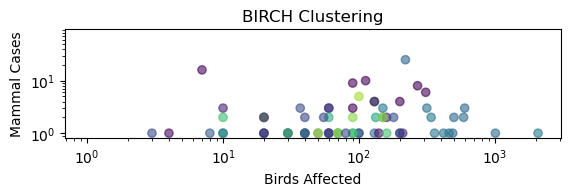

In [ ]:
# BIRCH plot
plt.subplot(3, 1, 2)
plt.scatter(X['birds_affected'], X['mammal_cases'], c=birch_predictions, cmap='viridis', alpha=0.6)
plt.xlabel('Birds Affected')
plt.ylabel('Mammal Cases')
plt.title('BIRCH Clustering')
plt.yscale('log')
plt.xscale('log')

In [ ]:
# Create a list to store values and the values of k
score_kmeans = []
score_agglomerative = []
score_birch = []

# Create a list to set the range of k values to test
k = list(range(2, 11))

In [ ]:
# For each model, we iterate through the different cluster count (`i`). 
# Then, calculate the variance ratio for each algorithm, given that specified cluster count.

for i in k:
    # Kmeans variance and score
    k_model = KMeans(n_clusters=i, n_init='auto', random_state=0)
    k_model.fit(X_scaled_imputed)
    labels = k_model.labels_
    score = metrics.calinski_harabasz_score(X_scaled_imputed, labels)    
    score_kmeans.append(score)
    
    # AgglomerativeClustering variance and score
    agglo_model = AgglomerativeClustering(n_clusters=i)
    labels = agglo_model.fit_predict(X_scaled_imputed)
    score = metrics.calinski_harabasz_score(X_scaled_imputed, labels)    
    score_agglomerative.append(score)    
    
    # Birch variance and score
    birch_model = Birch(n_clusters=i)
    birch_model.fit(X_scaled_imputed)
    labels = birch_model.labels_
    score = metrics.calinski_harabasz_score(X_scaled_imputed, labels)    
    score_birch.append(score)

In [ ]:
# Display the scores. 
display(score_kmeans)
display(score_agglomerative)
display(score_birch)

[731.140854365254,
 573.8763352974856,
 590.079460245232,
 689.2665217330974,
 694.3717966820946,
 700.6676637088494,
 671.7660441368613,
 574.2995012890128,
 628.0605936056486]

[579.2874795175775,
 563.4583980850845,
 584.211429701626,
 592.3566403630867,
 608.0503827673056,
 594.2004335832855,
 561.7157341551342,
 537.9087188773414,
 522.5663581227637]

[381.1691232982074,
 399.6924857819917,
 480.08036900748124,
 470.44793143594416,
 415.0896033036438,
 383.3102487705278,
 423.20161083864934,
 463.1532169949933,
 436.81151799168555]